In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [30]:
sc.settings.set_figure_params(
    dpi=80,
    frameon=False,  
)
plt.rcParams['axes.grid'] = False

In [3]:
adata = sc.read_h5ad('integrated.h5ad')
adata

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 33564 × 19958
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', '_scvi_raw_norm_scaling', 'cell type', 'cell_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'cell_type_colors', 'de_genes', 'de_genes_scvi', 'dendrogram_leiden_0_25', 'leiden', 'leiden_0_25', 'leiden_0_25_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'raw_counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [4]:
# adata is already normalized using 
# sc.pp.normalize_total(adata, target_sum = 1e4)
# sc.pp.log1p(adata)

In [5]:
sc.tl.rank_genes_groups(
    adata,
    groupby="sample",
    method="wilcoxon",
    key_added="dea_by_sample"
)

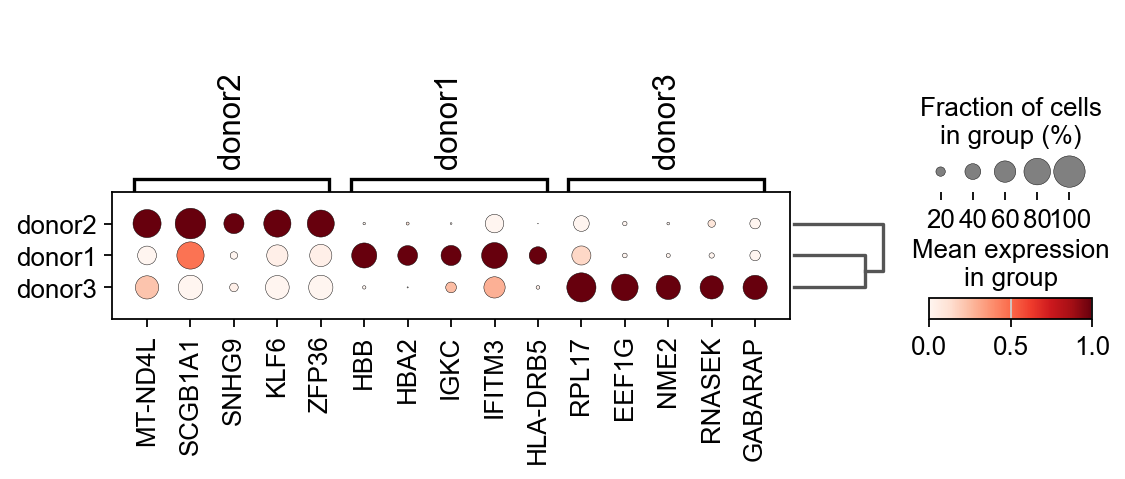

In [26]:
sc.pl.rank_genes_groups_dotplot(
    adata, 
    groupby="sample", 
    standard_scale="var", 
    n_genes=5,
    key='dea_by_sample'
    )

In [7]:
de = sc.get.rank_genes_groups_df(adata, group=None, key='dea_by_sample')
de.head(3)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,donor1,HBB,106.147530,5.586857,0.0,0.0
1,donor1,HBA2,76.668602,4.800794,0.0,0.0
2,donor1,IGKC,67.459335,3.495630,0.0,0.0


In [8]:
de_mod = de.set_index('names')
de_mod.index.name = 'gene'
de_mod.head(3)

,group,scores,logfoldchanges,pvals,pvals_adj
gene,,,,,
HBB,donor1,106.147530,5.586857,0.0,0.0
HBA2,donor1,76.668602,4.800794,0.0,0.0
IGKC,donor1,67.459335,3.495630,0.0,0.0


#### Volcano plot of DE genes

C:\Users\19utk\AppData\Local\Temp\ipykernel_78956\2115690489.py:15: RuntimeWarning: divide by zero encountered in log10
  non_sig['pvals_adj'].apply(lambda x: -np.log10(x)),
C:\Users\19utk\AppData\Local\Temp\ipykernel_78956\2115690489.py:20: RuntimeWarning: divide by zero encountered in log10
  down['pvals_adj'].apply(lambda x: -np.log10(x)),
C:\Users\19utk\AppData\Local\Temp\ipykernel_78956\2115690489.py:25: RuntimeWarning: divide by zero encountered in log10
  up['pvals_adj'].apply(lambda x: -np.log10(x)),


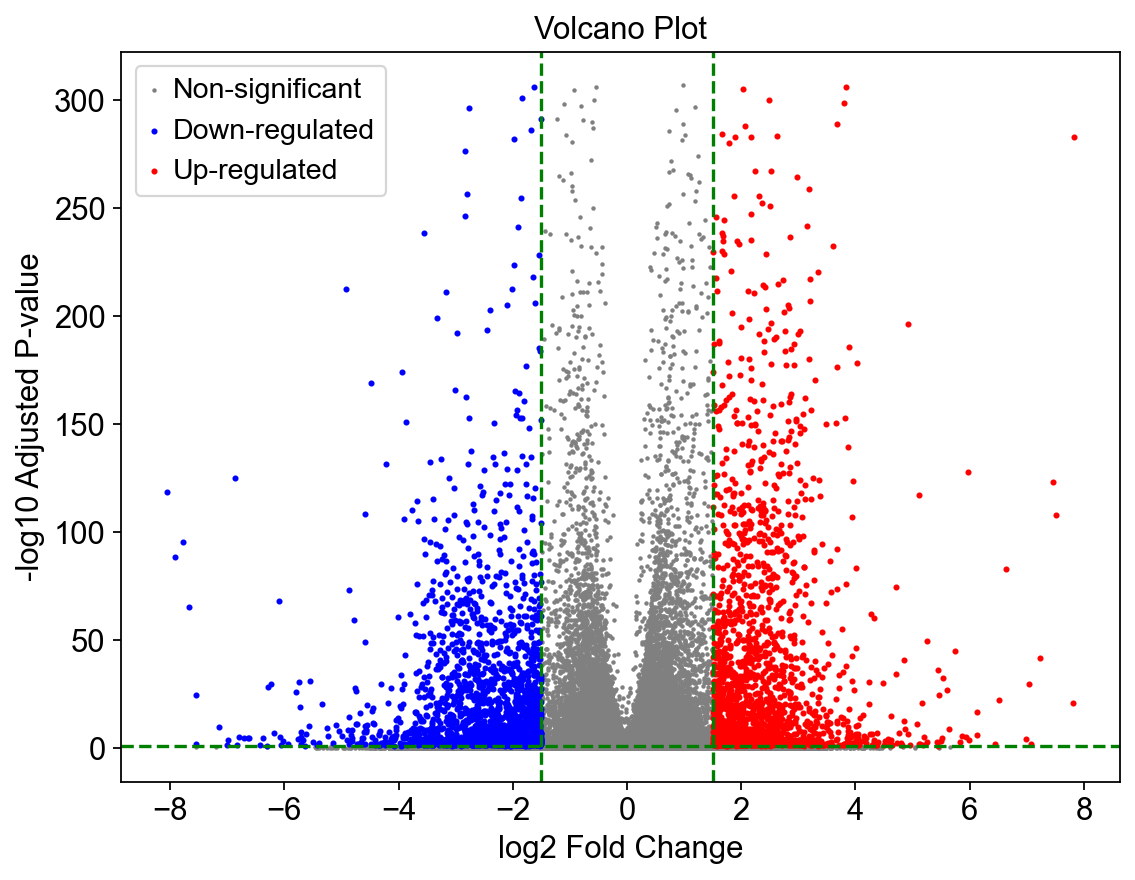

In [31]:

# Define thresholds
fc_thresh = 1.5                
pval_thresh = 0.05            

# Classify genes
down = de_mod[(de_mod['logfoldchanges'] <= -fc_thresh) & (de_mod['pvals_adj'] <= pval_thresh)]
up = de_mod[(de_mod['logfoldchanges'] >= fc_thresh) & (de_mod['pvals_adj'] <= pval_thresh)]
non_sig = de_mod[~de_mod.index.isin(down.index.union(up.index))]  

# Plot
plt.figure(figsize=(8,6))

# Plot non-significant genes first (grey)
plt.scatter(non_sig['logfoldchanges'], 
            non_sig['pvals_adj'].apply(lambda x: -np.log10(x)), 
            s=1, color='grey', label='Non-significant')

# Plot down-regulated genes (blue)
plt.scatter(down['logfoldchanges'], 
            down['pvals_adj'].apply(lambda x: -np.log10(x)), 
            s=3, color='blue', label='Down-regulated')

# Plot up-regulated genes (red)
plt.scatter(up['logfoldchanges'], 
            up['pvals_adj'].apply(lambda x: -np.log10(x)), 
            s=3, color='red', label='Up-regulated')

# Axes labels
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 Adjusted P-value")

# Threshold lines
plt.axvline(-fc_thresh, color="green", linestyle="--")
plt.axvline(fc_thresh, color="green", linestyle="--")
plt.axhline(-np.log10(pval_thresh), color="green", linestyle="--")

# Legend
plt.legend()
plt.title("Volcano Plot")
plt.show()


In [10]:
de = sc.get.rank_genes_groups_df(adata, group=None, key='dea_by_sample')
de = de[(de.pvals_adj < 0.05) & (abs(de.logfoldchanges) > 1.5)]
de = de.sort_values(by='logfoldchanges', ascending=False)
de

,group,names,scores,logfoldchanges,pvals,pvals_adj
39946,donor3,PALM2-AKAP2,42.434986,9.067512,0.000000e+00,0.000000e+00
39936,donor3,TMEM35B,48.873753,8.533098,0.000000e+00,0.000000e+00
39966,donor3,DBNDD2,36.145107,7.830329,4.440729e-286,1.452919e-283
41664,donor3,AC245407.2,9.849944,7.805624,6.858212e-23,6.736033e-22
40198,donor3,UPK3BL1,22.314484,7.515612,2.673060e-110,1.636471e-108
...,...,...,...,...,...,...
19536,donor1,DBNDD2,-17.374865,-7.661331,1.279074e-67,4.666867e-66
39696,donor2,PALM2-AKAP2,-20.966455,-7.769325,1.327961e-97,5.019592e-96
19698,donor1,PALM2-AKAP2,-20.210546,-7.915711,7.906886e-91,4.420326e-89
19794,donor1,TMEM35B,-23.395945,-8.062241,4.699709e-121,3.957671e-119


In [11]:
# top 20 DE genes per donor
top_genes = (
    de.sort_values("logfoldchanges", ascending=False)
      .groupby("group")
      .head(20)
)
top_genes = top_genes['names'].tolist()


C:\Users\19utk\AppData\Local\Temp\ipykernel_78956\3115808355.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


In [12]:
adata_de = adata[:, top_genes].copy()

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
expr = adata_de.to_df()
expr.head(3)

,PALM2-AKAP2,TMEM35B,DBNDD2,AC245407.2,UPK3BL1,SERPINA3,GALNT4,ATP6V0C,SERPINB4,LIME1,...,IGLC3,HBA1,IGKC,ALAS2,AHSP,KRT5,JCHAIN,IGHA1,NTS,F2RL3
AAACCCAAGCCTCTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.779905,0.0,0.0,0.0,0.0,0.464132,0.0,0.0
AAACCCAAGCGACTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACCCAAGCGTATGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.582547,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [14]:
expr["sample"] = adata_de.obs["sample"].values
expr.head(3)

,PALM2-AKAP2,TMEM35B,DBNDD2,AC245407.2,UPK3BL1,SERPINA3,GALNT4,ATP6V0C,SERPINB4,LIME1,...,HBA1,IGKC,ALAS2,AHSP,KRT5,JCHAIN,IGHA1,NTS,F2RL3,sample
AAACCCAAGCCTCTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.779905,0.0,0.0,0.0,0.0,0.464132,0.0,0.0,donor1
AAACCCAAGCGACTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,donor1
AAACCCAAGCGTATGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.582547,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,donor1


In [15]:
expr_mean = expr.groupby("sample").mean().T 
expr_mean.head()

C:\Users\19utk\AppData\Local\Temp\ipykernel_78956\1218869604.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_mean = expr.groupby("sample").mean().T


sample,donor1,donor2,donor3
PALM2-AKAP2,0.000777,0.000881,0.368496
TMEM35B,0.000629,0.001480,0.332393
DBNDD2,0.000625,0.001884,0.253774
AC245407.2,0.000287,0.000261,0.059446
UPK3BL1,0.000332,0.001137,0.127662


In [16]:
# (gene expression in a donor - mean of that gene across donors) / standard deviation of that gene across donors
expr_z = pd.DataFrame(
    zscore(expr_mean, axis=1),       
    index=expr_mean.index,           
    columns=expr_mean.columns         
)
expr_z.head()

sample,donor1,donor2,donor3
PALM2-AKAP2,-0.707409,-0.706805,1.414214
TMEM35B,-0.709828,-0.704382,1.414210
DBNDD2,-0.712392,-0.701808,1.414200
AC245407.2,-0.706642,-0.707572,1.414214
UPK3BL1,-0.713823,-0.700369,1.414192


In [17]:
expr_z.shape

(60, 3)

#### Histogram

Text(0.5, 1.0, 'DE Genes Heatmap (z-normalized)')

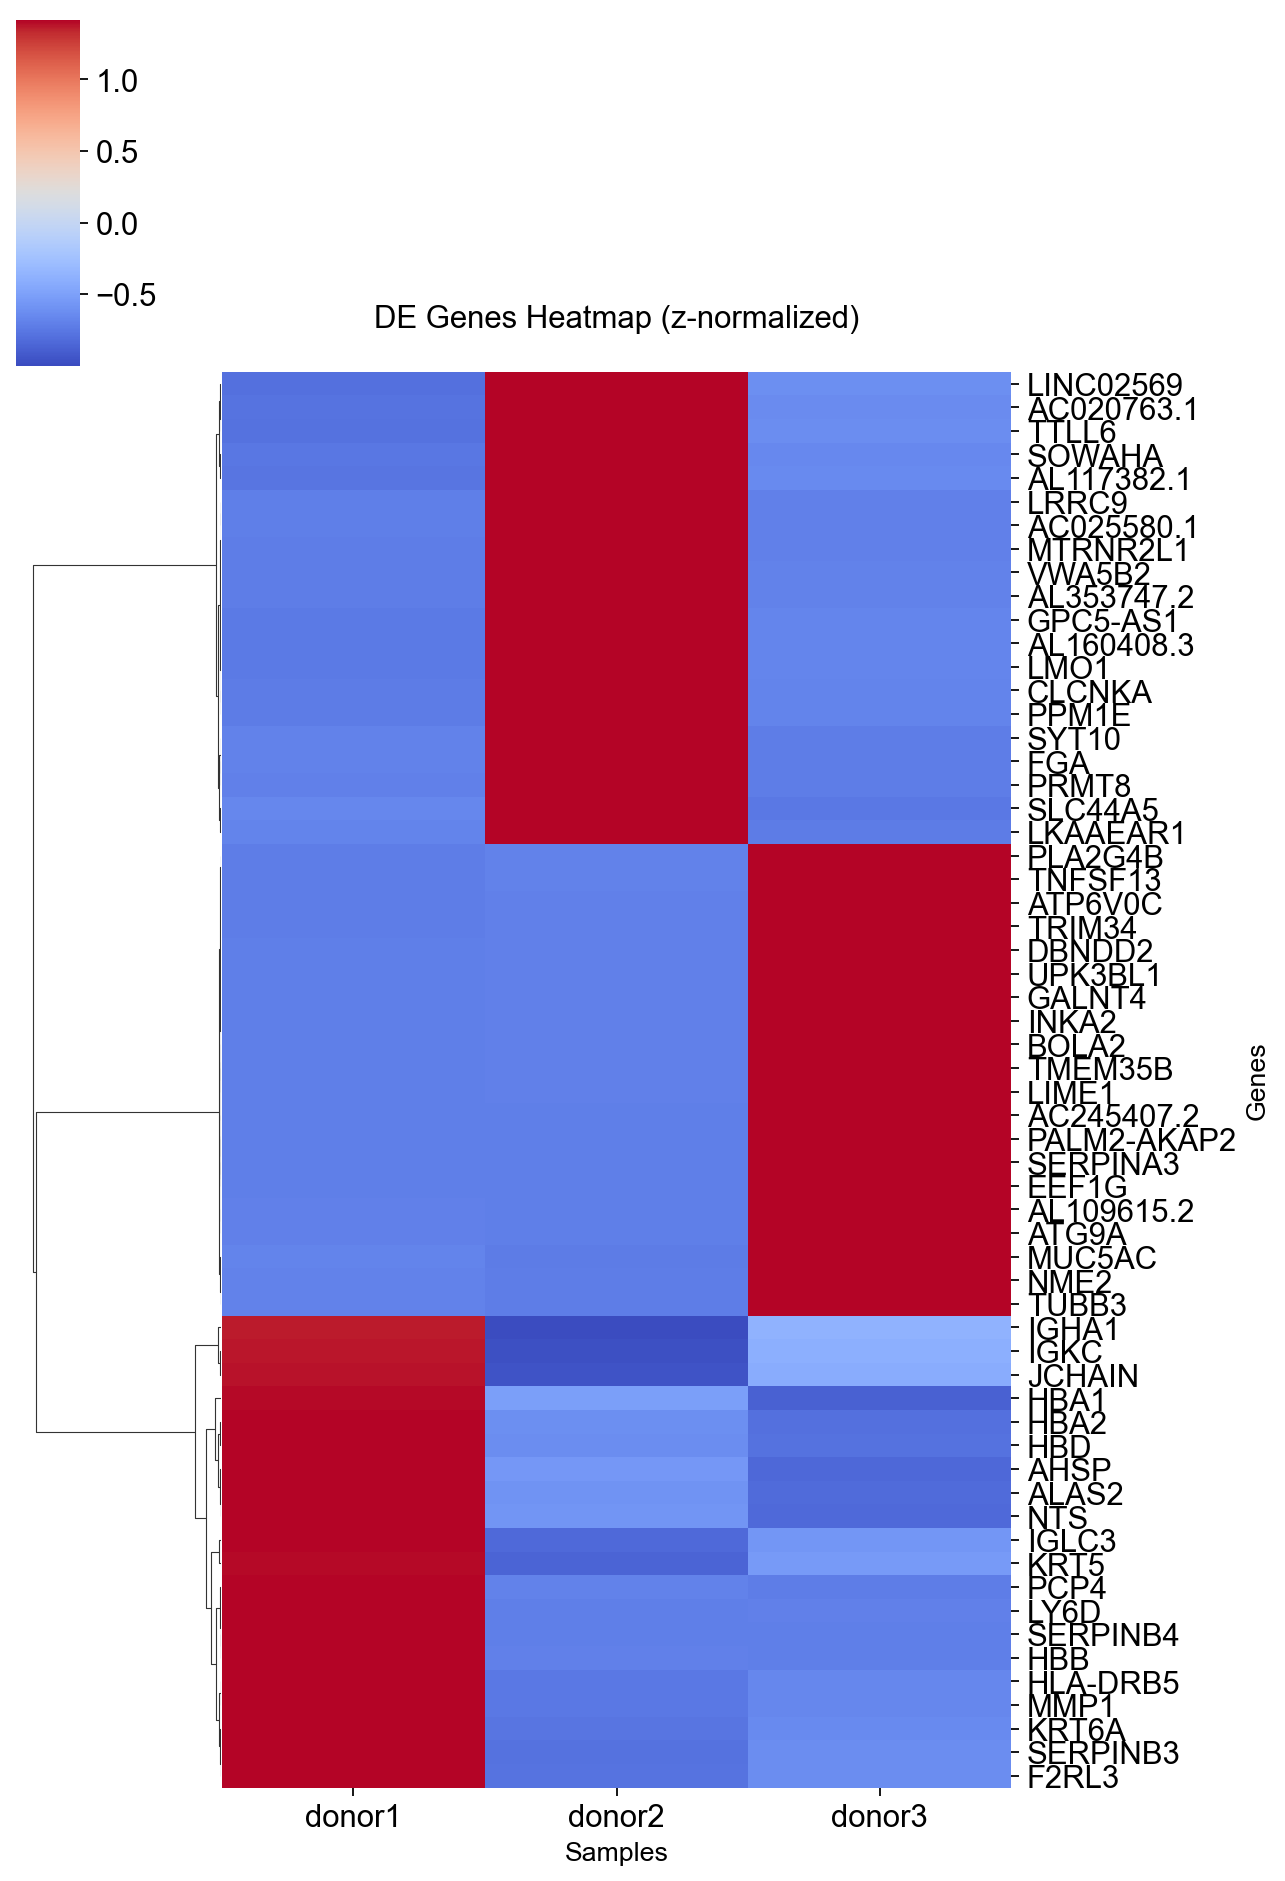

In [32]:
g = sns.clustermap(expr_z,
                   cmap="coolwarm",
                   col_cluster=False,   
                   row_cluster=True,    
                   figsize=(8, 12),     
                   yticklabels=True,
                    linewidths=0)    

# Add labels and title
g.ax_heatmap.set_xlabel("Samples", fontsize=12)
g.ax_heatmap.set_ylabel("Genes", fontsize=12)
g.ax_heatmap.set_title("DE Genes Heatmap (z-normalized)", fontsize=14, pad=20)



In [34]:
adata.write_h5ad('integrated.h5ad')